# Diffuse 511 Spectral Fit in Galactic Coordinates

This notebook fits the spectrum for the 511 keV emission in the Galaxy. It can be used as a general template for fitting diffuse/extended sources in Galactic coordinates. For a general introduction into spectral fitting with cosipy, see the continuum_fit tutorial.<br>

This notebook uses two 511 keV emission models, first a test model and then a realistic multi-component model. 

All input models are available here: <br>
https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511 <br>

The toy 511 model consists of two components: an extended Gaussian source (5 degree extension) and a point source. In the first part of this tutorial, we fit the data with just the single extended Gaussian component, i.e. we ignore the point source component. This is done as a simplification, and as will be seen, it already provides a good fit. In the second part of this tutorial we use a model consisting of both components. 

The realistic input models consist of a bulge component (with an extended Gaussian source and a point source) as well as a disk component with different spectral characteristics. In the third part of this tutorial we use this model. 

For the background we use just the cosmic photons. 

This tutotrial also walks through all the steps needed when performing a spectral fit, starting with the unbinned data, i.e. creating the combined data set, and binning the data. 

For the first two examples, you will need the following files (available on wasabi):<br>
**20280301_3_month.ori <br>
cosmic_photons_3months_unbinned_data.fits.gz <br>
511_Testing_3months.fits.gz <br>
SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 <br>
psr_gal_511_DC2.h5** <br>

The binned data products are available on wasabi, so you can also start by loading the binned data directly. <br>

For the third example, we start with the binned data, and you will need: 
<br>**combined_binned_data_thin_disk.hdf5** <br>

**WARNING:** If you run into memory issues creating the combined dataset or binning the data on your own, start by just loading the binned data directly. See the dataIO example for how to deal with memory issues. <br>

In [7]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.response import PointSourceResponse
from cosipy.threeml.custom_functions import Wide_Asymm_Gaussian_on_sphere, SpecFromDat
from cosipy.util import fetch_wasabi_file
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList, update_logging_level
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time
import h5py as h5
from histpy import Axis, Axes
import sys
from histpy import Histogram

## Get the data
The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size. 

In [ ]:
# ori file:
# wasabi path: COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori
# File size: 684 MB
fetch_wasabi_file('COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori')

In [ ]:
# cosmic photons:
# wasabi path: COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz
# File size: 8.5 GB
fetch_wasabi_file('COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz')

In [ ]:
# 511 test model:
# wasabi path: COSI-SMEX/DC2/Data/Sources/511_Testing_3months_unbinned_data.fits.gz
# File size: 850.6 MB
fetch_wasabi_file('COSI-SMEX/DC2/Data/Sources/511_Testing_3months_unbinned_data.fits.gz')

In [ ]:
# detector response:
# wasabi path: COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
# File size: 350.4 MB 
fetch_wasabi_file('COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5')

In [ ]:
# point source response:
# wasabi path: COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz
# File size: 3.82 GB
fetch_wasabi_file('COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz')
os.system("gzip -d psr_gal_511_DC2.h5.gz")

In [ ]:
# Binned data products:
# Note: This is not needed if you plan to bin the data on your own. 
# wasabi path: COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame 
# File sizes: 689.2 MB, 182.0 MB, 739.8 MB, 697.0 MB, respectively. 
file_list = ['cosmic_photons_binned_data.hdf5','gal_511_binned_data.hdf5','combined_binned_data.hdf5','combined_binned_data_thin_disk.hdf5']

for each in file_list:
    fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/%s' %each)

## Create the combined data
We will combine the 511 source and the cosmic photon background, which will be used as our dataset. <br>
This only needs to be done once.<br>
You can skip this cell if you already have the combined data file.

In [10]:
# Define instance of binned data class:
instance = BinnedData("Gal_511.yaml")

# Combine files:
input_files = ["cosmic_photons_3months_unbinned_data.fits.gz","511_Testing_3months_unbinned_data.fits.gz"]
instance.combine_unbinned_data(input_files, output_name="combined_data")


adding cosmic_photons_3months_unbinned_data.fits.gz...


adding 511_Testing_3months_unbinned_data.fits.gz...



## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip this cell if you already have the binned data files.

In [11]:
# Bin 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.get_binned_data(unbinned_data="511_Testing_3months_unbinned_data.fits.gz", output_name="gal_511_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [12]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [13]:
# Bin combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.get_binned_data(unbinned_data="combined_data.fits.gz", output_name="combined_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [ ]:
# Load 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.load_binned_data_from_hdf5(binned_data="gal_511_binned_data.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.load_binned_data_from_hdf5(binned_data="combined_binned_data.hdf5")

## Define source
The injected source has both an extended componenent and a point source component, <br>
but to start with we will ignore the point source component, <br>
and see how well we can describe the data with just the extended component. <br>
Define the extended source:

In [ ]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Let's make some plots to look at the extended source:

Text(0.5, 0, 'Energy [keV]')

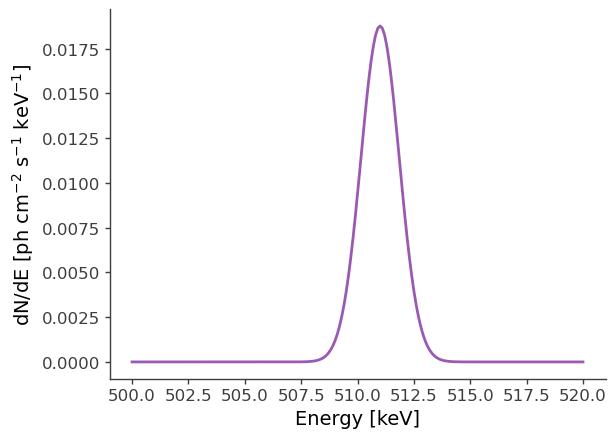

In [6]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = src1.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)

An extended source in astromodels corresponds to a skymap, which is normalized so that the sum over the entire sky, multiplied by the pixel area, equals 1. The pixel values in the skymap serve as weights, which we can use to scale the input spectrum, in order to get the model counts for any location on the sky. This is all handled internally within cosipy, but for demonstration purposes, let's take a look at the skymap:

In [7]:
# Define healpix map matching the detector response:
skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = skymap.pix2skycoord(range(skymap.npix))
pix_area = skymap.pixarea().value

# Fill skymap with values from extended source: 
skymap[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg) 

# Check normalization:
print("summed map: " + str(np.sum(skymap)*pix_area))

summed map: 0.9974653836229359


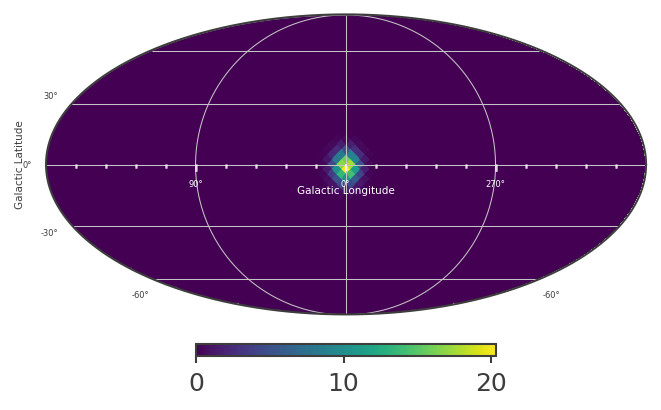

In [8]:
# Plot healpix map:
plot, ax = skymap.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

(1e-50, 1)

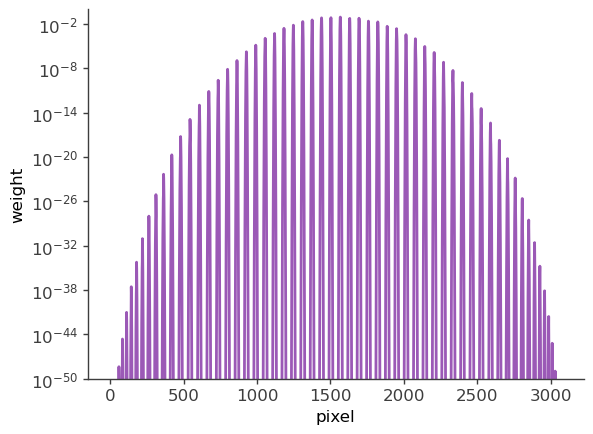

In [9]:
# Plot weights directly
# Note: for extended sources the weights also need to include the pixel area.
plt.semilogy(skymap[:]*pix_area)
plt.ylabel("weight")
plt.xlabel("pixel")
plt.ylim(1e-50,1)

## Setup the COSI 3ML plugin and perform the likelihood fit
Load the detector response, ori file, and precomputed point source response in Galactic coordinates:

In [ ]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

Setup the COSI 3ML plugin:

In [ ]:
%%time

# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

... loading the pre-computed image response ...
--> done
CPU times: user 1min 55s, sys: 37.4 s, total: 2min 32s
Wall time: 2min 49s


Perform likelihood fit: 

In [6]:
%%time 

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

11:55:08 INFO      set the minimizer to minuit                                             ]8;id=641391;file:///discover/nobackup/ckarwin/Software/COSI/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11475;file:///discover/nobackup/ckarwin/Software/COSI/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.

WARNING RuntimeWarning: invalid value encountered in log



11:56:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=619529;file:///discover/nobackup/ckarwin/Software/COSI/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=819028;file:///discover/nobackup/ckarwin/Software/COSI/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.6951 +/- 0.0025) x 10^-2,1 / (cm2 s)
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,-0.40
-0.40,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


CPU times: user 6min, sys: 3min 20s, total: 9min 21s
Wall time: 1min 36s


(                                      value  negative_error  positive_error  \
 gaussian.spectrum.main.Gaussian.F  0.046951       -0.000025        0.000025   
 background_cosi                    0.932137       -0.004667        0.004841   
 
                                       error         unit  
 gaussian.spectrum.main.Gaussian.F  0.000025  1 / (cm2 s)  
 background_cosi                    0.004754               ,
        -log(likelihood)
 cosi      -1.527559e+07
 total     -1.527559e+07)

## Results
First, let's just print the results. <br>

In [7]:
results = like.results
results.display()

# Print a summary of the optimized model:
print(results.optimized_model["gaussian"])

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.6951 +/- 0.0025) x 10^-2,1 / (cm2 s)
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,-0.40
-0.40,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


  * gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.046951164320587706
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
       

Now let's make some plots. <br>
Let's first look at the best-fit spectrum:

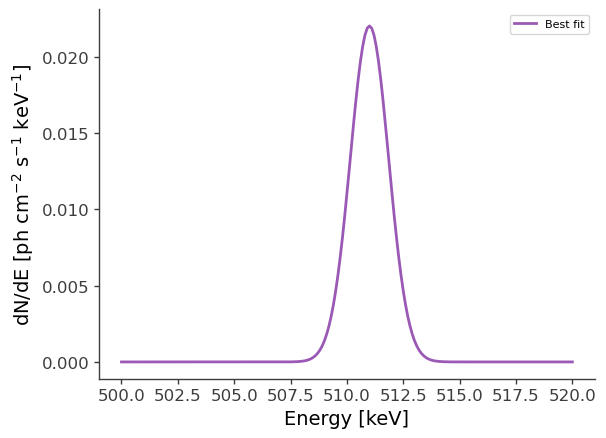

In [8]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux = results.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux, label = "Best fit")


plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Now let's compare the predicted counts to the injected counts:

Error: [2129.064008]


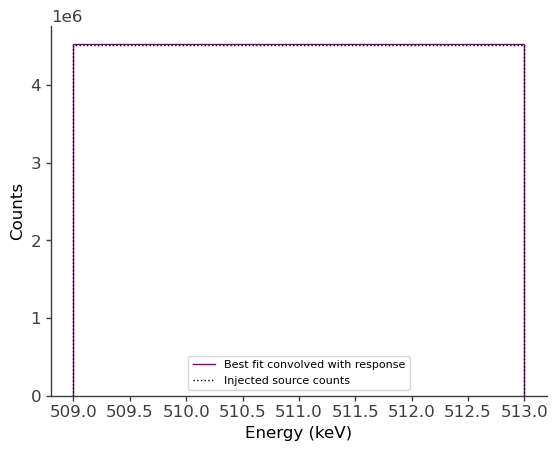

In [9]:
# Get expected counts from likelihood scan (i.e. best-fit convolved with response):
total_expectation = cosi._expected_counts['gaussian']

# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511.binned_data.axes['Em'].edges.value
binned_energy = gal_511.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

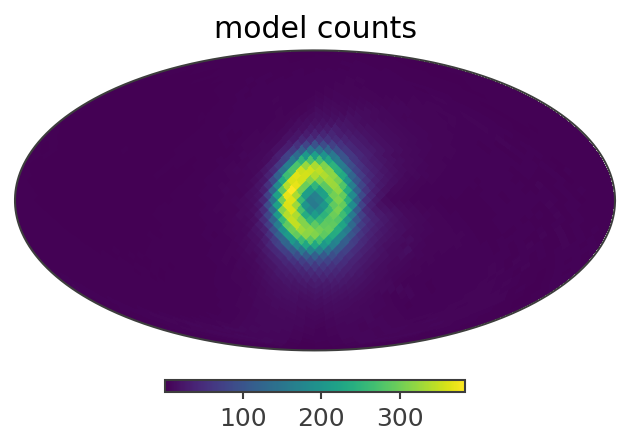

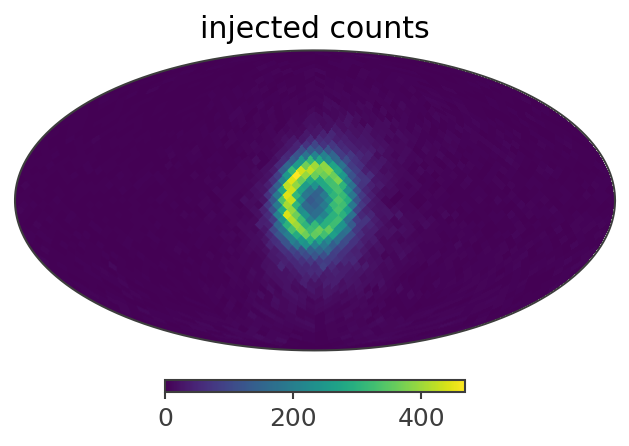

In [10]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

Here is a summary of the results:

Injected model (extended source): <br>
F = 4e-2 ph/cm2/s <br>

Best-fit: <br>
F = (4.6951 +/- 0.0025)e-2 ph/cm2/s <br>

We see that the best-fit values are very close to the injected values. The small difference is likely due to the fact that the injected model also has a point source component (which we've ignored), having the same specrtum, with a normalization of F = 1e-2 ph/cm2/s. In the next example we'll see if this point source component can be detected. 

## **********************************************************
## Example 2: Perform Analysis with Two Components

Define the point source. <br>
We'll add this to the model, and keep just the normalization free.

In [11]:
# Note: Astromodels only takes ra,dec for point source input:
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')

# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 1e-2 / u.cm / u.cm / u.s  
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum2 = Gaussian()
spectrum2.F.value = F.value
spectrum2.F.unit = F.unit
spectrum2.F.min_value = Fmin.value
spectrum2.F.max_value = Fmax.value
spectrum2.mu.value = mu.value
spectrum2.mu.unit = mu.unit
spectrum2.sigma.value = sigma.value
spectrum2.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum2.F.free = True
spectrum2.mu.free = False
spectrum2.sigma.free = False

# Define source:
src2 = PointSource('point_source', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=spectrum2)

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
print(src2.spectrum.main.shape)

# We can also get a summary of the source info as follows:
#src2.display()

  * description: A Gaussian function
  * formula: $ K \frac{1}{\sigma \sqrt{2 \pi}}\exp{\frac{(x-\mu)^2}{2~(\sigma)^2}} $
  * parameters:
    * F:
      * value: 0.01
      * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
      * min_value: 0.0
      * max_value: 1.0
      * unit: s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: true
    * mu:
      * value: 511.0
      * desc: Central value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * sigma:
      * value: 0.85
      * desc: standard deviation
      * min_value: 1.0e-12
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false



Redefine the first source.<br> 
We'll keep just the normalization free. 

In [12]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s 
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.F.min_value = Fmin.value
spectrum.F.max_value = Fmax.value
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: 0.0
            * max_value: 1.0
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Setup the COSI 3ML plugin using two sources in the model:

In [13]:
%%time 

# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1, src2)  # Model with two sources.

... loading the pre-computed image response ...
--> done
CPU times: user 2min 10s, sys: 41.5 s, total: 2min 52s
Wall time: 3min 10s


Display the model:

In [14]:
model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  1
Particle sources  0

Free parameters (2):
--------------------

                                      value min_value max_value      unit
gaussian.spectrum.main.Gaussian.F      0.04       0.0       1.0  s-1 cm-2
point_source.spectrum.main.Gaussian.F  0.01       0.0       1.0  s-1 cm-2

Fixed parameters (9):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Before we perform the fit, let's first change the 3ML console logging level, in order to mimimize the amount of console output.

In [25]:
# This is a simple workaround for now to prevent a lot of output. 
from threeML import update_logging_level
update_logging_level("CRITICAL")

Perform the likelihood fit:

In [18]:
%%time
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.6951 +/- 0.0025) x 10^-2,1 / (cm2 s)
point_source.spectrum.main.Gaussian.F,(0.0 +/- 1.3) x 10^-9,1 / (cm2 s)
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,-0.01,-0.40
-0.01,1.00,-0.03
-0.40,-0.03,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


CPU times: user 7min 24s, sys: 3min 55s, total: 11min 20s
Wall time: 1min 46s


(                                              value  negative_error  \
 gaussian.spectrum.main.Gaussian.F      4.695126e-02   -2.403110e-05   
 point_source.spectrum.main.Gaussian.F  5.975791e-13    2.623492e-10   
 background_cosi                        9.320815e-01   -4.914467e-03   
 
                                        positive_error         error  \
 gaussian.spectrum.main.Gaussian.F        2.433950e-05  2.418530e-05   
 point_source.spectrum.main.Gaussian.F    1.929678e-09  1.096013e-09   
 background_cosi                          4.582905e-03  4.748686e-03   
 
                                               unit  
 gaussian.spectrum.main.Gaussian.F      1 / (cm2 s)  
 point_source.spectrum.main.Gaussian.F  1 / (cm2 s)  
 background_cosi                                     ,
        -log(likelihood)
 cosi      -1.527559e+07
 total     -1.527559e+07)

We see that the normalization of the point source has gone to zero, and we essentially get the same results as the first fit. This is not entirely surprising, considering that the two components have a high degree of degeneracy, and the point source is subdominant. 

Note (CK): The injected model may not be exactly the same as the astromodel, because MEGAlib uses a cutoff of the Gaussian spectral distribution at 3 sigma.   

## *****************************************
## Example 3: Working With a Realistic Model

## Read in the binned data
We will start with the binned data, since we already learned how to bin data: 

In [2]:
# background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# combined data:
data_combined_thin_disk = BinnedData("Gal_511.yaml")
data_combined_thin_disk.load_binned_data_from_hdf5(binned_data="combined_binned_data_thin_disk.hdf5")

## Define source
This defines a multi-component source with a disk and gaussian component. The disk and bulge components have different spectral characteristics. Spatially, the bulge component is the sum of three different spatial models, with majority of the flux  "narrow bulge" with 

In [3]:
# Spectral Definitions...

models = ["centralPoint","narrowBulge","broadBulge","disk"]

# several lists of parameters for, in order, CentralPoint, NarrowBulge, BroadBulge, and Disk sources
mu         = [511.,511.,511., 511.]*u.keV
sigma      = [0.85,0.85,0.85, 1.27]*u.keV
F          = [0.00012, 0.00028, 0.00073, 1.7e-3]/u.cm/u.cm/u.s
K          = [0.00046, 0.0011, 0.0027, 4.5e-3]/u.cm/u.cm/u.s

SpecLine   = [Gaussian(),Gaussian(),Gaussian(),Gaussian()]
SpecOPs    = [SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat")]

# Set units and fitting parameters; different definition for each spectral model with different norms
for i in range(4):
    SpecLine[i].F.unit = F[i].unit
    SpecLine[i].F.value = F[i].value
    SpecLine[i].F.min_value =0
    SpecLine[i].F.max_value=1
    SpecLine[i].mu.value = mu[i].value
    SpecLine[i].mu.unit = mu[i].unit
    SpecLine[i].sigma.unit = sigma[i].unit
    SpecLine[i].sigma.value = sigma[i].value

    SpecOPs[i].K.value = K[i].value
    SpecOPs[i].K.unit = K[i].unit
    
    SpecLine[i].sigma.free = False
    SpecLine[i].mu.free = False
    SpecLine[i].F.free = False#True
    SpecOPs[i].K.free = False # not fitting the amplitude of the OPs component for now, since we are only using the 511 response! 

SpecLine[-1].F.free = True# actually do fit the flux of the disk component

# Generate Composite Spectra
SpecCentralPoint= SpecLine[0] + SpecOPs[0]
SpecNarrowBulge = SpecLine[1] + SpecOPs[1]
SpecBroadBulge  = SpecLine[2] + SpecOPs[2]
SpecDisk        = SpecLine[3] + SpecOPs[3]

In [4]:
# Define Spatial Model Components
MapNarrowBulge = Gaussian_on_sphere(lon0=359.75,lat0=-1.25, sigma = 2.5)
MapBroadBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 8.7)
MapDisk = Wide_Asymm_Gaussian_on_sphere(lon0 = 0, lat0 = 0, a=90, e = 0.99944429,theta=0)

# Fix fitting parameters (same for all models)
for map in [MapNarrowBulge,MapBroadBulge]:
    map.lon0.free=False
    map.lat0.free=False
    map.sigma.free=False
    
MapDisk.lon0.free=False
MapDisk.lat0.free=False
MapDisk.a.free=False
MapDisk.e.free=True#False
MapDisk.theta.free=False

For the Wide_Asymm_Gaussian_on_sphere model, note that e is the eccentricity of the Gaussian ellipse, defined such that the scale height b of the disk is given by $b = a \sqrt{(1-e^2)}$

In [5]:
# Define Spatio-spectral models

# Bulge
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')
ModelCentralPoint = PointSource('centralPoint', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=SpecCentralPoint)
ModelNarrowBulge = ExtendedSource('narrowBulge',spectral_shape=SpecNarrowBulge,spatial_shape=MapNarrowBulge)
ModelBroadBulge = ExtendedSource('broadBulge',spectral_shape=SpecBroadBulge,spatial_shape=MapBroadBulge)

# Disk
ModelDisk = ExtendedSource('disk',spectral_shape=SpecDisk,spatial_shape=MapDisk)

In [9]:
ModelDisk

* disk (extended source):
    * shape:
      * lon0:
        * value: 0.0
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: 0.0
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * a:
        * value: 90.0
        * desc: Standard deviation of the Gaussian distribution (major axis)
        * min_value: 0.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * e:
        * value: 0.99944429
        * desc: Excentricity of Gaussian ellipse, e^2 = 1 - (b/a)^2, where b is the standard
          * deviation of the Gaussian distribution (minor axis)
        * min_value: 0.0
        * max_value: 1.0
        * unit: ''
        * is_normalization: false
      * theta:
        * value: 0.0
        * desc: inclination of major axis to a line of constant latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * composite:
          * F_1:
            * value: 0.0017
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: 0.0
            * max_value: 1.0
            * unit: s-1 cm-2
            * is_normalization: false
          * mu_1:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma_1:
            * value: 1.27
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
          * K_2:
            * value: 0.004499999999999998
            * desc: Normalization
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * dat_2:
            * value: OPsSpectrum.dat
        * polarization: {}

Make some plots to look at these new extended sources:

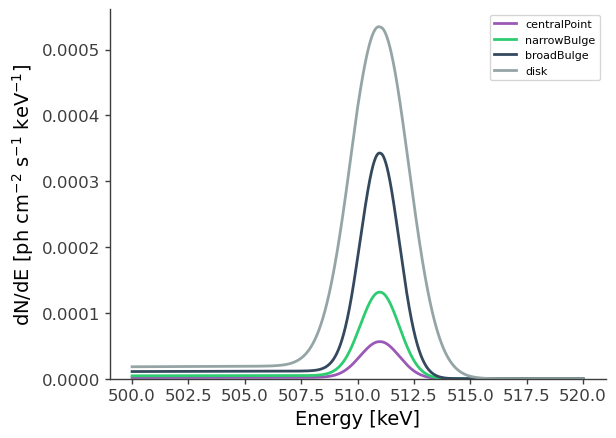

In [10]:
# Plot spectra at 511 keV
energy = np.linspace(500.,520.,10001)*u.keV
fig, axs = plt.subplots()
for label,m in zip(models,
                   [ModelCentralPoint,ModelNarrowBulge,ModelBroadBulge,ModelDisk]):
    dnde = m.spectrum.main.composite(energy)
    axs.plot(energy, dnde,label=label)

axs.legend()
axs.set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
axs.set_xlabel("Energy [keV]", fontsize=14);
plt.ylim(0,);
#axs[0].set_yscale("log")

The orthopositronium spectral component appears as the low-energy tail of the 511 keV line.

In [11]:
# Define healpix map matching the detector response:
nside_model = 2**4
scheme='ring'
is_nested = (scheme == 'nested')
coordsys='G'

mBroadBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mNarrowBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mPointBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mDisk = HealpixMap(nside = nside_model, scheme=scheme, dtype = float,coordsys=coordsys)

coords = mDisk.pix2skycoord(range(mDisk.npix)) # common among all the galactic maps...

pix_area = mBroadBulge.pixarea().value # common among all the galactic maps with the same pixelization

# Fill skymap with values from extended source: 
mNarrowBulge[:] = ModelNarrowBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBroadBulge[:] = ModelBroadBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBulge = mBroadBulge + mNarrowBulge
mDisk[:] = ModelDisk.spatial_shape(coords.l.deg, coords.b.deg)

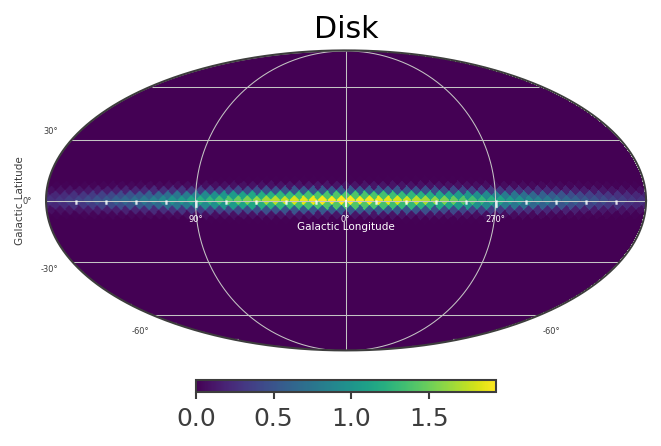

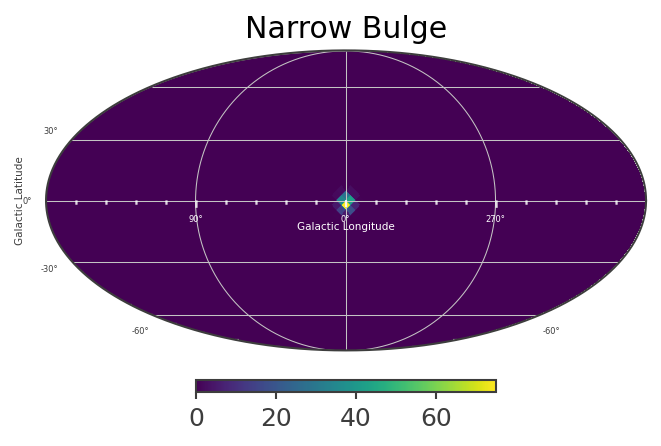

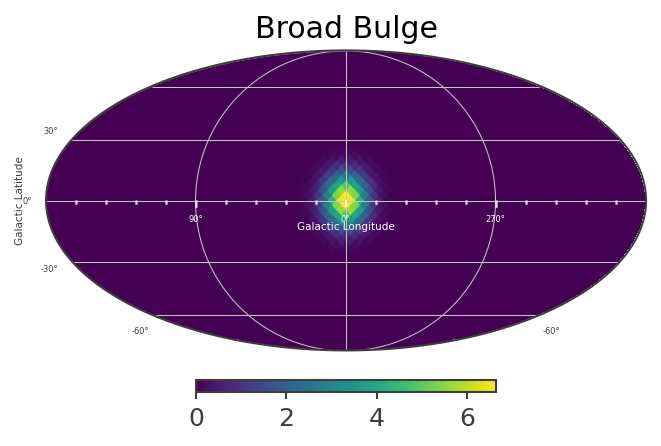

In [12]:
List_of_Maps = [mDisk,mNarrowBulge,mBroadBulge]
List_of_Names = ["Disk","Narrow Bulge","Broad Bulge", ]

for n, m in zip(List_of_Names,List_of_Maps):
    plot,ax = m.plot(ax_kw={"coord":"G"})
    ax.grid();
    lon = ax.coords['glon']
    lat = ax.coords['glat']
    lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
    lat.set_axislabel('Galactic Latitude',fontsize=5)
    lon.display_minor_ticks(True)
    lat.display_minor_ticks(True)
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lon.set_ticks(color='white',alpha=0.6)
    lat.set_ticks(color='white',alpha=0.6)
    lon.set_ticklabel(color='white',fontsize=4)
    lat.set_ticklabel(fontsize=4)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    ax.set_title(n)

## Instantiate the COSI 3ML plugin and perform the likelihood fit
The following two cells should be run only if not already run in previous examples...

In [13]:
# if not previously loaded in example 1, load the response, ori, and psr: 
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

In [14]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

We should re-run the following cell every time we set up a new fit:

In [15]:
%%time 

# Instantiate the COSI 3ML plugin, using combined data for the thin disk
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined_thin_disk.binned_data.project('Em', 'Phi', 'PsiChi'),# data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),       # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
plugins = DataList(cosi)

... loading the pre-computed image response ...
--> done
CPU times: user 1min 56s, sys: 37 s, total: 2min 33s
Wall time: 2min 51s


In [16]:
# add sources to thin disk and thick disk models 
totalModel =  Model(ModelDisk, ModelBroadBulge,ModelNarrowBulge,ModelCentralPoint)
totalModel.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  3
Particle sources  0

Free parameters (2):
--------------------

                                         value min_value max_value      unit
disk.Wide_Asymm_Gaussian_on_sphere.e  0.999444       0.0       1.0          
disk.spectrum.main.composite.F_1        0.0017       0.0       1.0  s-1 cm-2

Fixed parameters (27):
---------------------

                                               value min_value max_value  \
disk.Wide_Asymm_Gaussian_on_sphere.lon0          0.0       0.0     360.0   
disk.Wide_Asymm_Gaussian_on_sphere.lat0          0.0     -90.0      90.0   
disk.Wide_Asymm_Gaussian_on_sphere.a            90.0       0.0      90.0   
disk.Wide_Asymm_Gaussian_on_sphere.theta         0.0     -90.0      90.0   
disk.spectrum.main.composite.mu_1              511.0      None      None   
disk.spectrum.main.composite.sigma_1            1.27       0.0      None   
disk.spectrum.main.composite.K_2              0.0045       0.0    1000.0   
broadBulge.Gaussian_on_sphere.lon0               0.0       0.0     360.0   
broadBulge.Gaussian_on_sphere.lat0               0.0     -90.0      90.0   
broadBulge.Gaussian_on_sphere.sigma              8.7       0.0      20.0   
broadBulge.spectrum.main.composite.F_1       0.00073       0.0       1.0   
broadBulge.spectrum.main.composite.mu_1        511.0      None      None   
broadBulge...sigma_1                            0.85       0.0      None   
broadBulge.spectrum.main.composite.K_2        0.0027       0.0    1000.0   
narrowBulge.Gaussian_on_sphere.lon0           359.75       0.0     360.0   
narrowBulge.Gaussian_on_sphere.lat0            -1.25     -90.0      90.0   
narrowBulge.Gaussian_on_sphere.sigma             2.5       0.0      20.0   
narrowBulge.spectrum.main.composite.F_1      0.00028       0.0       1.0   
narrowBulge.spectrum.main.composite.mu_1       511.0      None      None   
narrowBulge...sigma_1                           0.85       0.0      None   
narrowBulge.spectrum.main.composite.K_2       0.0011       0.0    1000.0   
centralPoint.position.ra                  266.404988       0.0     360.0   
centralPoint.position.dec                 -28.936178     -90.0      90.0   
centralPoint.spectrum.main.composite.F_1     0.00012       0.0       1.0   
centralPoint...mu_1                            511.0      None      None   
centralPoint...sigma_1                          0.85       0.0      None   
centralPoint.spectrum.main.composite.K_2     0.00046       0.0    1000.0   

                                                    unit  
disk.Wide_Asymm_Gaussian_on_sphere.lon0              deg  
disk.Wide_Asymm_Gaussian_on_sphere.lat0              deg  
disk.Wide_Asymm_Gaussian_on_sphere.a                 deg  
disk.Wide_Asymm_Gaussian_on_sphere.theta             deg  
disk.spectrum.main.composite.mu_1                    keV  
disk.spectrum.main.composite.sigma_1                 keV  
disk.spectrum.main.composite.K_2          keV-1 s-1 cm-2  
broadBulge.Gaussian_on_sphere.lon0                   deg  
broadBulge.Gaussian_on_sphere.lat0                   deg  
broadBulge.Gaussian_on_sphere.sigma                  deg  
broadBulge.spectrum.main.composite.F_1          s-1 cm-2  
broadBulge.spectrum.main.composite.mu_1              keV  
broadBulge...sigma_1                                 keV  
broadBulge.spectrum.main.composite.K_2    keV-1 s-1 cm-2  
narrowBulge.Gaussian_on_sphere.lon0                  deg  
narrowBulge.Gaussian_on_sphere.lat0                  deg  
narrowBulge.Gaussian_on_sphere.sigma                 deg  
narrowBulge.spectrum.main.composite.F_1         s-1 cm-2  
narrowBulge.spectrum.main.composite.mu_1             keV  
narrowBulge...sigma_1                                keV  
narrowBulge.spectrum.main.composite.K_2   keV-1 s-1 cm-2  
centralPoint.position.ra                             deg  
centralPoint.position.dec                            deg  
centralPoint.spectrum.

Before we perform the fit, let's first change the 3ML console logging level, in order to mimimize the amount of console output.

In [26]:
# This is a simple workaround for now to prevent a lot of output. 
from threeML import update_logging_level
update_logging_level("CRITICAL")

In [21]:
%%time 
# likelihood of data + model
like = JointLikelihood(totalModel, plugins, verbose = True)
like.fit()

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


Best fit values:

,result,unit
parameter,,
disk.Wide_Asymm_Gaussian_on_sphere.e,(9.9985 +/- 0.0005) x 10^-1,
disk.spectrum.main.composite.F_1,(1.643 +/- 0.011) x 10^-3,1 / (cm2 s)
background_cosi,(9.906 +/- 0.032) x 10^-1,


Correlation matrix:

1.00,-0.33,0.09
-0.33,1.00,-0.60
0.09,-0.60,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-166772.754018
total,-166772.754018


Values of statistical measures:

,statistical measures
AIC,-333547.508036
BIC,-333545.508036


CPU times: user 30min 29s, sys: 15min 41s, total: 46min 11s
Wall time: 8min 12s


(                                         value  negative_error  \
 disk.Wide_Asymm_Gaussian_on_sphere.e  0.999853       -0.000045   
 disk.spectrum.main.composite.F_1      0.001643       -0.000011   
 background_cosi                       0.990610       -0.003091   
 
                                       positive_error     error         unit  
 disk.Wide_Asymm_Gaussian_on_sphere.e        0.000045  0.000045               
 disk.spectrum.main.composite.F_1            0.000011  0.000011  1 / (cm2 s)  
 background_cosi                             0.003209  0.003150               ,
        -log(likelihood)
 cosi     -166772.754018
 total    -166772.754018)

## Results

In [23]:
# thin disk model to data
results = like.results
results.display()

Best fit values:

,result,unit
parameter,,
disk.Wide_Asymm_Gaussian_on_sphere.e,(9.9985 +/- 0.0005) x 10^-1,
disk.spectrum.main.composite.F_1,(1.643 +/- 0.011) x 10^-3,1 / (cm2 s)
background_cosi,(9.906 +/- 0.032) x 10^-1,


Correlation matrix:

1.00,-0.33,0.09
-0.33,1.00,-0.60
0.09,-0.60,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-166772.754018
total,-166772.754018


Values of statistical measures:

,statistical measures
AIC,-333547.508036
BIC,-333545.508036


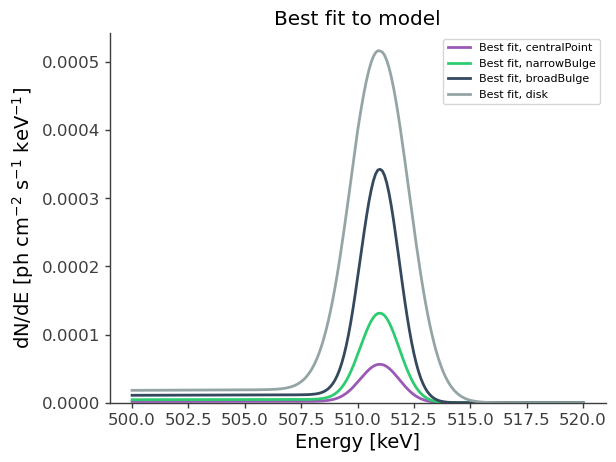

In [24]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
fluxes = {}

for model in models: 
    fluxes[model] = results.optimized_model[model].spectrum.main.shape(energy)

fig,ax = plt.subplots()
for model in models:
    ax.plot(energy, fluxes[model], label = f"Best fit, {model}",ls='-')
ax.set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
ax.set_xlabel("Energy [keV]", fontsize=14)
ax.set_title("Best fit to model")
ax.legend()
ax.set_ylim(0,);

In summary, we fitted the flux and eccentricity of the disk only, with the all parameters of the bulge component fixed. Considering $b = a \sqrt{(1-e^2)}$, we recovered the following fitted parameters:

##### Component..... Injected........... Best Fit           
b...................... 3$^{\circ}$..................... 1.6$^{+0.2\circ}_{- 0.3}$      
Disk................. 1.7e-3/cm$^2$/s.... (1.64 $\pm$ 0.01)e-3 /cm$^2$/s  
Background .....1........................0.991 $\pm$ 0.003  

You can play around with the fitting to find the best parameters for fitting the scale height of the disk, changing the initial values for the fit and which parameters are allowed to vary. 